# Model Explainability Analysis
We employ SHAP for model explainability.

In [1]:
# imports

import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
import utils
import shap
shap.initjs()

In [2]:
# read data
windowsize = 30
stepsize = 1
X_train, y_train, groups_train, X_test, y_test, groups_test = utils.read_data(windowsize, stepsize)

# get train data as numpy arrays
X_train = X_train.to_numpy()

# set up pipeline
pipe = Pipeline([('scaler', MaxAbsScaler()),
                 ('etc', ExtraTreesClassifier(bootstrap=True, 
                                              criterion="log_loss",
                                              max_features=0.6,
                                              min_samples_leaf=5,
                                              min_samples_split=14,
                                              n_estimators=50,
                                              random_state=0))])

pipe.fit(X_train, y_train.values.ravel())

Window Size:  30   Stepsize:  1
train shape:  (22038, 71)
test shape:  (5509, 71)
test columns:  Index(['bvp_BVP_mean', 'bvp_BVP_std', 'bvp_BVP_sum', 'bvp_BVP_skewness',
       'bvp_BVP_kurtosis', 'bvp_BVP_peaks', 'bvp_BVP_n_above_mean',
       'bvp_BVP_n_below_mean', 'bvp_BVP_n_sign_changes',
       'bvp_BVP_perm_entropy', 'bvp_BVP_svd_entropy', 'bvp_l2_min',
       'bvp_l2_n_above_mean', 'bvp_l2_n_below_mean', 'bvp_l2_n_sign_changes',
       'bvp_l2_perm_entropy', 'acc_x_mean', 'acc_x_std', 'acc_x_energy',
       'acc_x_skewness', 'acc_x_kurtosis', 'acc_x_peaks', 'acc_x_lineintegral',
       'acc_x_n_above_mean', 'acc_x_n_sign_changes', 'acc_x_iqr', 'acc_y_mean',
       'acc_y_std', 'acc_y_energy', 'acc_y_skewness', 'acc_y_kurtosis',
       'acc_y_peaks', 'acc_y_n_above_mean', 'acc_y_n_sign_changes',
       'acc_y_iqr', 'acc_y_svd_entropy', 'acc_z_mean', 'acc_z_std',
       'acc_z_min', 'acc_z_max', 'acc_z_energy', 'acc_z_skewness',
       'acc_z_kurtosis', 'acc_z_peaks', 'acc_z_n_ab

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('etc',
                 ExtraTreesClassifier(bootstrap=True, criterion='log_loss',
                                      max_features=0.6, min_samples_leaf=5,
                                      min_samples_split=14, n_estimators=50,
                                      random_state=0))])

In [3]:
#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(pipe['etc'])

#apply the preprocessing to X_test
observations = pipe['scaler'].transform(X_test)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

X has feature names, but MaxAbsScaler was fitted without feature names


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


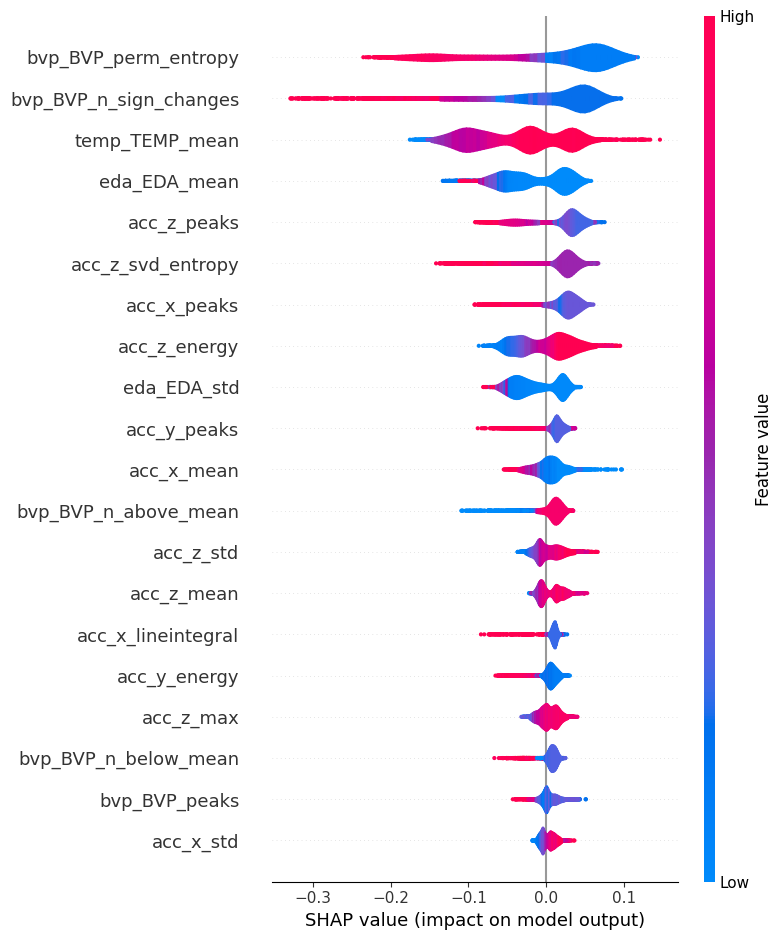

In [4]:
# plot SHAP model explanation
shap.summary_plot(shap_values[0], X_test, plot_type="violin")

In [5]:
# Print total number of features
print('The total number of features is:',X_test.shape[1])

The total number of features is: 71


### Interpretation

I chose SHAP for model explainability as it can create intuitive plots about feature importance.

What we have to consider here is the total number of features, which is 71. We see the top features in the SHAP summary plot, but there are many more features with each contributing a small amount for the final explanation.

Nevertheless, the SHAP summary plot can help us with understanding the model. More explanation of the feature names can be found in the paper about the FLIRT library (https://doi.org/10.1016/j.cmpb.2021.106461)


We observe that the `perm_entropy` (permutation entropy) of the `BVP` (blood volume pulse) signal is deemed the feature with the most significant impact on the model output. Permutation entropy is defined as a measure of complexity of timeseries data (http://stubber.math-inf.uni-greifswald.de/pub/full/prep/2001/11.pdf). For lower values for this feature, the model is likelier to predict 1 (stress). Given the data we have, it is very difficult for a layperson of the medical field to interpret results like this. What I could imagine is that if there is a high stress level, the pulse is generally high, driving down the complexity of the BVP value. Similarly, we could guess the interpretation of the other features - a medical expert should be involved for more knowledgeable interpretations of these results.